In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import os

In [3]:
#from OpSimSummary import summarize_opsim as oss
import sncosmo

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
#import cov_utils as cutils

### Some required Setup

Setup bandpasses to be used

In [5]:
# sncosmo Bandpasses required for fitting
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


Read in the light curve

In [53]:
lc = sncosmo.read_lc('example_data/lsst_median.dat')

In [55]:
pd.DataFrame(np.asarray(lc)).head()

,index,time,band,flux,fluxerr,zp,zpsys,SNR,fiveSigmaDepth,night,DetectionEfficiency,modelFlux,deviation
0,10,49542.000000,r,7.989467e-10,2.820028e-11,0,ab,28.331164,24.7,49542,NaN,7.989467e-10,1.764052
1,5,49542.000000,i,7.894048e-10,5.130814e-11,0,ab,15.385567,24.0,49542,NaN,7.894048e-10,0.400157
2,9,49526.000000,r,4.112269e-10,2.714882e-11,0,ab,15.147133,24.7,49526,NaN,4.112269e-10,0.978738
3,1,49536.666667,g,3.084444e-10,2.060987e-11,0,ab,14.965860,25.0,49536,NaN,3.084444e-10,2.240893
4,11,49558.000000,r,3.687259e-10,2.703108e-11,0,ab,13.640813,24.7,49558,NaN,3.687259e-10,1.867558


Setup the SNCosmo model

In [58]:
model = sncosmo.Model(source='salt2-extended')
model.set(**{'z':0.5, 't0':49540, 'x0':1.0e-5})
print model

source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 1.0
  phases     : [-20, .., 50] days
  wavelengths: [300, .., 18000] Angstroms
parameters:
  z  = 0.5
  t0 = 49540.0
  x0 = 1.0000000000000001e-05
  x1 = 0.0
  c  = 0.0


Plot the light curve

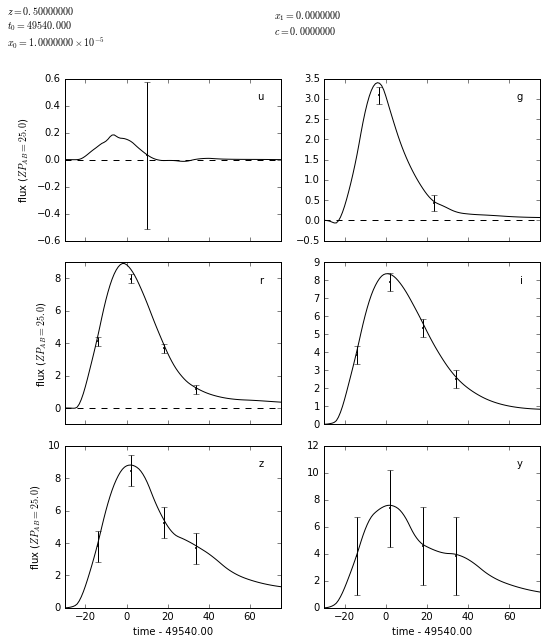

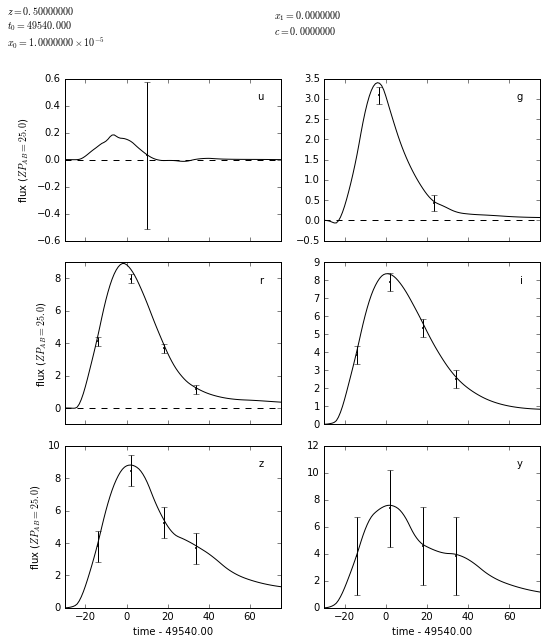

In [59]:
sncosmo.plot_lc(lc, model=model, color='k', pulls=False)

Obtain the mcmc_output

In [14]:
mcmc_out = sncosmo.mcmc_lc(lc, model=model, 
                vparam_names=['t0', 'x0', 'x1', 'c'], 
                bounds={'c':(-1., 1.), 'x1':(-5.0, 5.0)}, 
                minsnr=0., modelcov=False)

#  New Demos

In [60]:
import analyzelcFits as anf

In [61]:
t = anf.ResChar.fromSNCosmoRes(mcmc_out)

Now we can look at the MCMC samples as they were

In [64]:
t.samples.head()

,t0,x0,x1,c
0,49539.822529,0.000009,-0.012187,0.009128
1,49539.844177,0.000009,-0.018012,0.008804
2,49539.808875,0.000009,-0.008514,0.009333
3,49539.661480,0.000009,-0.130812,0.006230
4,49539.702547,0.000009,-0.145789,0.013560


We can convert to 'SAlt samples' which gives us a few more parameters 
In calculating mu, values of alpha, beta, MDelta are assumed

In [65]:
samples = t.salt_samples()

In [66]:
samples.head()

,t0,x0,x1,c,mB,MDelta,mu
0,49539.822529,0.000009,-0.012187,0.009128,12.578241,0,12.604832
1,49539.844177,0.000009,-0.018012,0.008804,12.577820,0,12.602590
2,49539.808875,0.000009,-0.008514,0.009333,12.578506,0,12.606247
3,49539.661480,0.000009,-0.130812,0.006230,12.577525,0,12.578523
4,49539.702547,0.000009,-0.145789,0.013560,12.588359,0,12.609983


Though we put in MDelta, this is currently 0, so we will remove it 

In [67]:
x = samples[['t0', 'x0', 'x1', 'c', 'mB','mu']]

In [68]:
x.head()

,t0,x0,x1,c,mB,mu
0,49539.822529,0.000009,-0.012187,0.009128,12.578241,12.604832
1,49539.844177,0.000009,-0.018012,0.008804,12.577820,12.602590
2,49539.808875,0.000009,-0.008514,0.009333,12.578506,12.606247
3,49539.661480,0.000009,-0.130812,0.006230,12.577525,12.578523
4,49539.702547,0.000009,-0.145789,0.013560,12.588359,12.609983


In [69]:
x.values

array([[  4.95398225e+04,   9.30472876e-06,  -1.21873907e-02,
          9.12832283e-03,   1.25782407e+01,   1.26048323e+01],
       [  4.95398442e+04,   9.30833548e-06,  -1.80120243e-02,
          8.80382503e-03,   1.25778199e+01,   1.26025901e+01],
       [  4.95398089e+04,   9.30245393e-06,  -8.51368041e-03,
          9.33298994e-03,   1.25785062e+01,   1.26062465e+01],
       ..., 
       [  4.95403442e+04,   9.20080867e-06,   4.49673464e-01,
          2.26212018e-02,   1.25904350e+01,   1.27235150e+01],
       [  4.95403601e+04,   9.18738805e-06,   4.77679221e-01,
          2.34913184e-02,   1.25920198e+01,   1.27317180e+01],
       [  4.95403601e+04,   9.18738805e-06,   4.77679221e-01,
          2.34913184e-02,   1.25920198e+01,   1.27317180e+01]])

In [70]:
from corner import corner

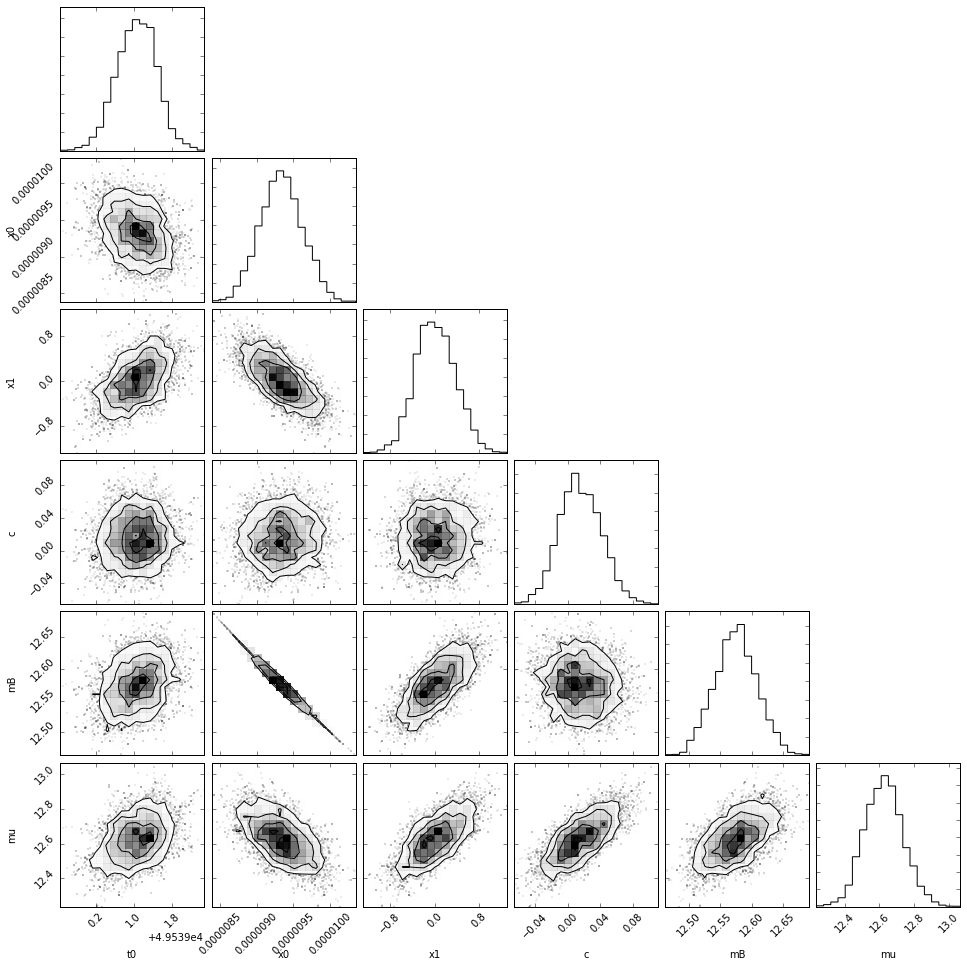

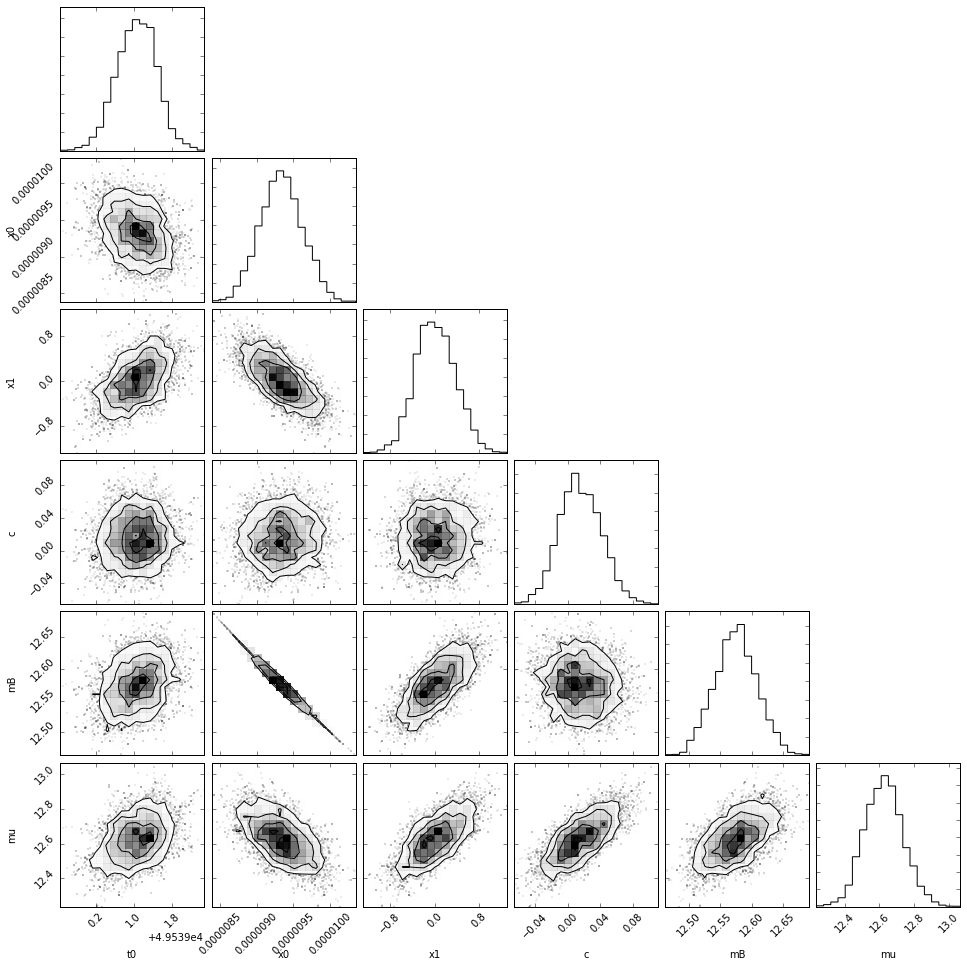

In [71]:
corner(x.values, labels=x.columns)

We can see the error on mu for these values of alpha and beta

In [72]:
t.salt_samples().mu.std()

0.11071937727040378

This is the covariance matrix that was read in as output of mcmc

In [73]:
t._covariance

array([[  1.74543158e-01,  -3.82729966e-08,   7.79721147e-02,
          6.96520026e-04],
       [ -3.82729966e-08,   8.28390174e-14,  -7.19081530e-08,
          5.36818159e-10],
       [  7.79721147e-02,  -7.19081530e-08,   1.26265796e-01,
          4.09228757e-04],
       [  6.96520026e-04,   5.36818159e-10,   4.09228757e-04,
          6.61063521e-04]])

We display it in a more easy to read format

In [74]:
t.covariance

,t0,x0,x1,c
t0,1.745432e-01,-3.827300e-08,7.797211e-02,6.965200e-04
x0,-3.827300e-08,8.283902e-14,-7.190815e-08,5.368182e-10
x1,7.797211e-02,-7.190815e-08,1.262658e-01,4.092288e-04
c,6.965200e-04,5.368182e-10,4.092288e-04,6.610635e-04


An advantage is that we can now get a covariance element very easily either by index or by parameter

In [78]:
t.covariance.ix['x0', 'x0']

8.283901739544437e-14

In [79]:
t.covariance.ix['x0', 'x1']

-7.1908153047167728e-08

In [80]:
t.covariance.iloc[1,2]

-7.1908153047167728e-08

For submatrices

In [81]:
t.covariance.ix[['x0', 'x1'], ['x0', 'x1']]

,x0,x1
x0,8.283902e-14,-7.190815e-08
x1,-7.190815e-08,1.262658e-01


In [82]:
import cov_utils as cu

In [83]:
cu.subcovariance(t.covariance, ['x0', 'c'])

,x0,c
x0,8.283902e-14,5.368182e-10
c,5.368182e-10,6.610635e-04


We can calculate the covariance of the parameters that go into the distance modulus formula
using a linear approximation

In [75]:
m = t.salt_covariance_linear(); m

,mB,x1,c
mB,0.001121,0.008363,-0.000062
x1,0.008363,0.126266,0.000409
c,-0.000062,0.000409,0.000661


We could have also used the mcmc samples to estimate the covariance without resorting to assumptions on linearity

In [76]:
ss = t.salt_samples()[['mB', 'x1', 'c']]

In [77]:
ss.cov()

,mB,x1,c
mB,0.001122,0.008369,-0.000063
x1,0.008369,0.126266,0.000409
c,-0.000063,0.000409,0.000661


Which match reasonably well

## Finally, some unrelated stuff about seaborn

In [84]:
import seaborn as sns

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [85]:
sns.set()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


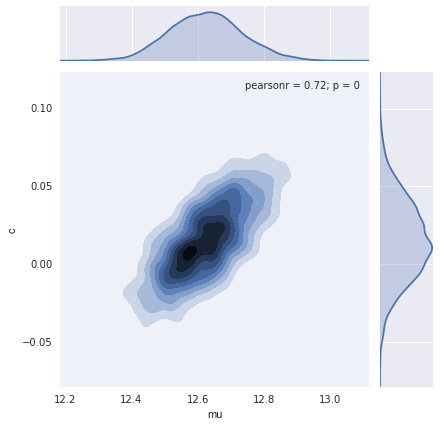

In [86]:
sns.jointplot(x='mu', y='c', data=samples, kind='kde')

In [87]:
from scipy import stats

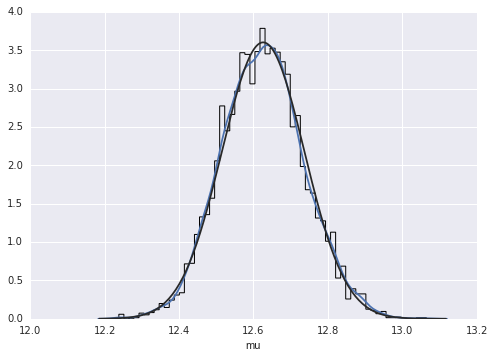

In [88]:
sns.distplot(samples.mu, hist=True, rug=False, hist_kws={'normed':1, 'histtype':'step', 
                                                         'lw':1, 'alpha':1, 'color':'k'}, 
             fit=stats.norm)


In [89]:
del samples['MDelta']

In [90]:
samples.head()

,t0,x0,x1,c,mB,mu
0,49539.822529,0.000009,-0.012187,0.009128,12.578241,12.604832
1,49539.844177,0.000009,-0.018012,0.008804,12.577820,12.602590
2,49539.808875,0.000009,-0.008514,0.009333,12.578506,12.606247
3,49539.661480,0.000009,-0.130812,0.006230,12.577525,12.578523
4,49539.702547,0.000009,-0.145789,0.013560,12.588359,12.609983


In [92]:
del samples['x0']

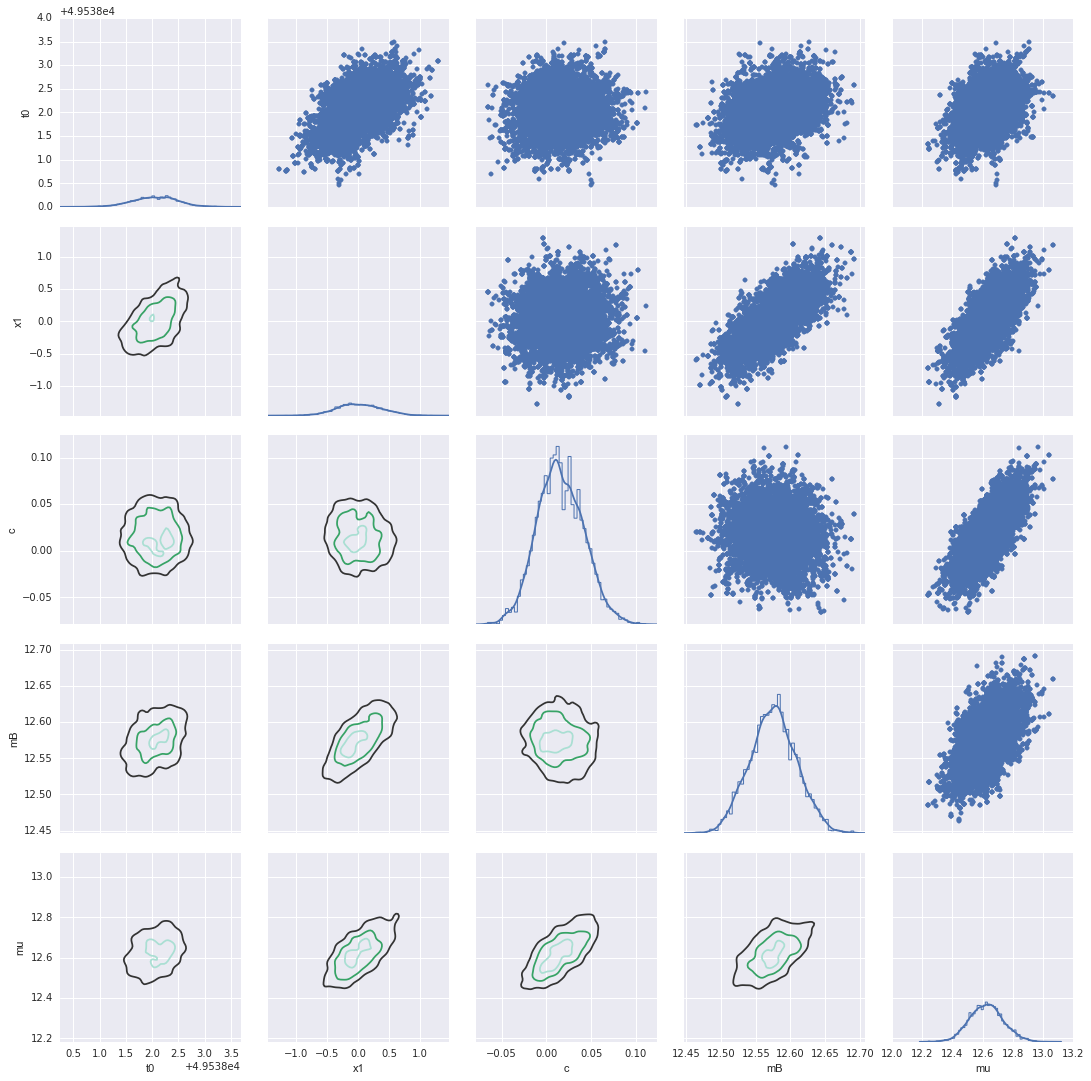

In [93]:
h = sns.PairGrid(samples);
h.map_upper(plt.scatter)
h.map_diag(sns.distplot, rug=False, hist_kws={'histtype':'step', 'alpha':1, 'lw':1})
h.map_lower(sns.kdeplot, legend=False, lw=3, n_levels=3)

In [ ]:
h.map(plt.scatter)